In [142]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from src.models.train_model import TimeSeriesGenerator
from src.models.zoo import LSTM_triggerNG, LSTM_WSAEs
import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

import pickle
import gc
p=print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
"""
Import Data.
"""
SYM='BTC'
Ty=1
Tx=72
channels=34
batch_size = 32
wavelet='HAAR'
X_train=np.load('../data/processed/X_train_{}_{}_{}x{}.npy'.format(SYM, wavelet, Tx, channels))
y_train=np.load('../data/processed/y_train_{}_{}_{}x{}.npy'.format(SYM, wavelet, Tx, channels))
X_test=np.load('../data/processed/X_test_{}_{}_{}x{}.npy'.format(SYM, wavelet, Tx, channels))
y_test=np.load('../data/processed/y_test_{}_{}_{}x{}.npy'.format(SYM, wavelet, Tx, channels))

In [144]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((15130, 72, 34), (797, 72, 34), (797, 1), (15130, 1))

In [145]:
model_X_train = X_train
model_X_test = X_test

In [122]:
"""
For creating a generator with a time series of wavelet transforms. Too expensive and redundant
"""
# train_gen = TimeSeriesGenerator(np.expand_dims(X_train,-1), y_train, length=24, sampling_rate=1, 
#                                batch_size=batch_size, batch_size_constant=True)
# test_gen = TimeSeriesGenerator(np.expand_dims(X_train,-1), y_train, length=24, sampling_rate=1, 
#                               batch_size=batch_size, batch_size_constant=True)

'\nFor creating a generator with a time series of wavelet transforms. Too expensive and redundant\n'

In [123]:
"""
Generator from scratch. Has been replaced by TimeSeriesGenerator, which was ripped from the old Keras release
"""
# from keras.utils import Sequence

# class TimeSequence(Sequence):

#     def __init__(self, x_set, y_set, length, batch_size):
#         self.x, self.y = x_set, y_set
#         self.length = length
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil((self.x.shape[0] - self.length) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_x = np.empty((self.batch_size, self.length, self.x.shape[1], self.x.shape[2], self.x.shape[3]))
        
#         start_x_idx = idx * self.length
#         start_y_idx = start_x_idx + self.length
#         end_y_idx = start_y_idx + self.batch_size
        
#         for ii in range(self.batch_size):
#             start_batch_item_x_idx = start_x_idx + ii
#             end_batch_item_x_idx = start_batch_item_x_idx + self.length
            
#             batch_x[ii,:,:,:,:] = self.x[start_batch_item_x_idx : end_batch_item_x_idx,:,:]
            
#         batch_y = self.y[start_y_idx:end_y_idx]

#         return batch_x, batch_y


'\nGenerator from scratch. Has been replaced by TimeSeriesGenerator, which was ripped from the old Keras release\n'

In [146]:
"""
Evaluate Dummy Models.
"""

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
        
    p('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, y_train)
    
    p('\nPerformance on train data:')
    dummy_predict_train = dummy.predict(X_train)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_train, y_pred=dummy_predict_train)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_train, y_pred=dummy_predict_train)))
    
    p('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_test, y_pred=dummy_predict_test)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MAE: 0.6704191833149541
mean MSE: 1.1434823688554288

Performance on test data:
mean MAE: 0.27617677289849457
mean MSE: 0.2203102561304603

Training dummy model on training data with strategy median ...

Performance on train data:
median MAE: 0.6703710389694876
median MSE: 1.143547094825167

Performance on test data:
median MAE: 0.2768240780719447
median MSE: 0.22082193727421412

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MAE: 0.6709792377853523
constant MSE: 1.143896644909049

Performance on test data:
constant MAE: 0.27555036295581686
constant MSE: 0.21959377436005295


In [125]:
"""
Remove if using generator
"""
# del X_train, X_test, y_train, y_test; gc.collect()

'\nRemove if using generator\n'

In [126]:
from keras.layers import Input, LSTM, BatchNormalization, Dense, Conv1D, Conv2D, TimeDistributed, Activation, Flatten, MaxPooling2D
from keras import Model

from keras.initializers import RandomNormal, Ones, Constant

In [127]:
# """
# Time distributed 2D conv. May be too expensive computationally and redundant
# """

# def lstm_model(input_shape, num_outputs, kernel_init='normal', bias_init='zeros'):
    
#     model_input = Input(batch_shape=input_shape, dtype='float32', name='input_1')

#     X = TimeDistributed(Conv2D(128, kernel_size=(8, 4), strides=(4, 3), kernel_initializer=kernel_init, bias_initializer=bias_init), name='conv_1')(model_input)
#     X = TimeDistributed(BatchNormalization(axis=-1), name='bn_1')(X)
#     X = TimeDistributed(Activation('relu'), name='relu_1')(X)   
#     X = TimeDistributed(MaxPooling2D((4, 2), strides=(2, 2)), name='mp_1')(X)
#     X = TimeDistributed(Flatten(), name='flat_1')(X)
    
#     X = LSTM(units=32, return_sequences=True, stateful=True, kernel_initializer=kernel_init, bias_initializer=bias_init, name='lstm_1')(X)
#     X = BatchNormalization(axis=-1, name='bn_2')(X)
    
#     X = LSTM(units=32, return_sequences=False, stateful=True, kernel_initializer=kernel_init, bias_initializer=bias_init, name='lstm_2')(X)
#     X = BatchNormalization(axis=-1, name='bn_3')(X)
    
#     X = Dense(num_outputs, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='linear', name='dense_1')(X) # time distributed  (linear)
    
#     model = Model(inputs=model_input, outputs=X)
#     return model

In [181]:
"""
Define model.
"""
model_type = 'LSTM_triggerNG'

if model_type == 'LSTM_triggerNG':
    model=LSTM_triggerNG(model_X_train.shape[1:], Ty)
elif model_type == 'LSTM_WSAEs':
    model=LSTM_WSAEs(model_X_train.shape[1:], Ty, 10)
else:
    p('NOT SUPPORTED')
    model=None
    
"""
If using a generator define this way.
"""
# model=lstm_model(ts_train[0][0].shape[:], Ty)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 72, 34)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 35, 196)           26852     
_________________________________________________________________
batch_normalization_59 (Batc (None, 35, 196)           784       
_________________________________________________________________
activation_17 (Activation)   (None, 35, 196)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 35, 128)           166400    
_________________________________________________________________
batch_normalization_60 (Batc (None, 35, 128)           512       
_________________________________________________________________
lstm_42 (LSTM)               (None, 128)               131584    
__________

In [183]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from time import time
"""
Set model training parameters.
"""
epochs = 10
batch_size = 32
learning_rate=.001
beta_1=0.9
beta_2=0.999
decay=0.01
# decay = learning_rate / epochs

"""
Compile and fit model.
"""
tensorboard = TensorBoard(log_dir='logs/{}'.format('no_dropout'))
opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, decay=decay)
model.compile(loss='mse', optimizer=opt, metrics=['mae'])

fit = model.fit(model_X_train, y_train,
                shuffle=False,
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(model_X_test, y_test),
                callbacks=[tensorboard]
               )
"""
For generator fitting ...
"""
# fit = model.fit_generator(
#     generator=ts_train,
#     shuffle=False,
#     epochs=epochs, 
#     max_queue_size=10,
#     workers=3,
#     use_multiprocessing=True,
#     validation_data=ts_test
# )

Train on 15130 samples, validate on 797 samples
Epoch 1/10
15130/15130 [==============================] - 67s 4ms/step - loss: 1.1837 - mean_absolute_error: 0.6987 - val_loss: 0.2375 - val_mean_absolute_error: 0.2991
Epoch 2/10
15130/15130 [==============================] - 52s 3ms/step - loss: 1.1186 - mean_absolute_error: 0.6716 - val_loss: 0.2628 - val_mean_absolute_error: 0.3339
Epoch 3/10
15130/15130 [==============================] - 51s 3ms/step - loss: 1.0932 - mean_absolute_error: 0.6666 - val_loss: 0.2847 - val_mean_absolute_error: 0.3618
Epoch 4/10
15130/15130 [==============================] - 52s 3ms/step - loss: 1.0686 - mean_absolute_error: 0.6620 - val_loss: 0.3063 - val_mean_absolute_error: 0.3880
Epoch 5/10
15130/15130 [==============================] - 57s 4ms/step - loss: 1.0451 - mean_absolute_error: 0.6573 - val_loss: 0.3301 - val_mean_absolute_error: 0.4148
Epoch 6/10
15130/15130 [==============================] - 54s 4ms/step - loss: 1.0219 - mean_absolute_error

'\nFor generator fitting ...\n'

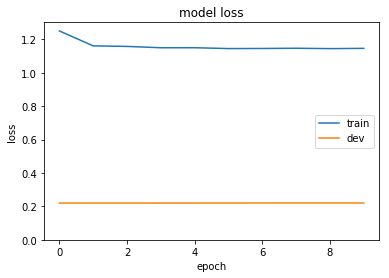

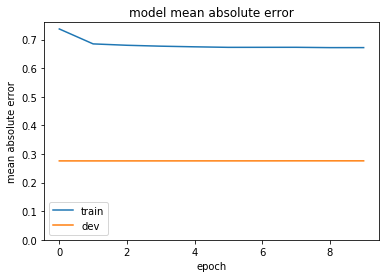

In [168]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='dev')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

"""
Check out mean absolute error from train and dev sets
"""
plt.plot(fit.history['mean_absolute_error'], label='train')
plt.plot(fit.history['val_mean_absolute_error'], label='dev')
plt.title('model mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

In [184]:
backtest=model.predict(model_X_train)
prediction = model.predict(model_X_test)

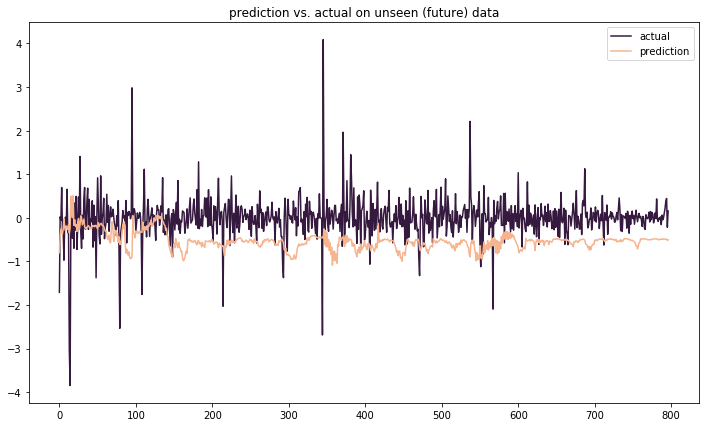

In [185]:
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(y_test, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(prediction, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on unseen (future) data')
plt.legend()

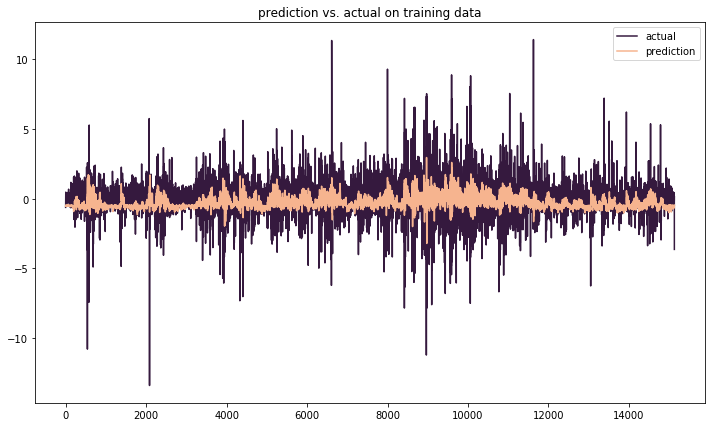

In [186]:
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(y_train, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(backtest, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on training data')
plt.legend()

In [141]:
"""
Save the model.
"""
model.save(filepath='../models/{}_cwt_{}x{}_{}_{}.h5'.format(model_type, Tx, channels, wavelet, SYM))